In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import sys, os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
torch.cuda.device_count()

2

In [3]:
device = torch.device("cuda" if torch.cuda.device_count() else "cpu")
print(device)

cuda


In [4]:
root_dir = "/home/bizon/tandem_repeats_finder"
data_dir = os.path.join(root_dir, "data")
train_fn = os.path.join(data_dir, "train.csv")
test_fn = os.path.join(data_dir, "test.csv")

In [5]:
train = np.loadtxt(train_fn, delimiter=',')
test = np.loadtxt(test_fn, delimiter=',')
print(train.shape)
print(test.shape)

(3750, 1474)
(1250, 1474)


In [6]:
#train[:, :-1] = (train[:, :-1] - np.min(train[:, :-1], axis=1, keepdims=True)) / (np.max(train[:, :-1], axis=1, keepdims=True) - np.min(train[:, :-1], axis=1, keepdims=True))
#test[:, :-1] = (test[:, :-1] - np.min(test[:, :-1], axis=1, keepdims=True)) / (np.max(test[:, :-1], axis=1, keepdims=True) - np.min(test[:, :-1], axis=1, keepdims=True))

## Create a validation set

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(train[:, :-1], 
                                                      train[:, -1], 
                                                      train_size=0.80, 
                                                      stratify=train[:, -1],
                                                      random_state=20)
print(f"Number of positive sample in train: {np.sum(y_train)}")
print(f"Number of positive sample in valid: {np.sum(y_valid)}")
train = np.concatenate((X_train, y_train.reshape(-1,1)), axis=1)
valid = np.concatenate((X_valid, y_valid.reshape(-1,1)), axis=1)

Number of positive sample in train: 322.0
Number of positive sample in valid: 81.0


## Dataset

In [8]:
class SignalsDataset(Dataset):
    
    def __init__(self, data):
        self.data_arr = data
        
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x) and label (y)
        """
        x = self.data_arr[index, :-1].reshape(-1, 1)
        y = self.data_arr[index, -1]
        return {'x': x.astype(float),
                'y': y.astype(float)}
    def __len__(self):
        return self.data_arr.shape[0]

In [9]:
train_dataset = SignalsDataset(train)
valid_dataset = SignalsDataset(valid)
test_dataset = SignalsDataset(test)
print(f"Number of samples in train: {len(train_dataset)}")
print(f"Number of samples in valid: {len(valid_dataset)}")
print(f"Number of samples in test: {len(test_dataset)}")

Number of samples in train: 3000
Number of samples in valid: 750
Number of samples in test: 1250


In [10]:
train_dataset[0]['x'].shape

(1473, 1)

## LSTM model class

In [11]:
class TandemRepeatLSTM(nn.Module):
    """
    model definition for LSTM model
    """
    def __init__(self, max_seq_len, num_input_features=1, num_hidden_states=5, num_layers=1):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(TandemRepeatLSTM, self).__init__()
        self.num_hidden_states = num_hidden_states
        self.lstm = nn.LSTM(num_input_features, num_hidden_states, num_layers)
        self.drop = nn.Dropout(p=0.1)
        #self.fc = nn.Linear(max_seq_len*num_hidden_states, 100)
        self.output = nn.Linear(num_hidden_states, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x_in):
        """
        Args:
            x_in (torch.Tensor):
                shape should be (#timestamps, #batches, #input_features)
        """
        lstm_out, (hn, cn) = self.lstm(x_in) #lstm_out: (seq_len, batch, hidden_size*num_layers)
        batch_size = lstm_out.size(1)
        #lstm_out = torch.transpose(lstm_out, 0, 1).contiguous().view(batch_size, -1)
        lstm_out = torch.transpose(lstm_out, 0, 1).contiguous() #lstm_out: (batch, seq_len, hidden_size*num_layers)
        lstm_out = lstm_out[:, -1, :]
        output = self.output(lstm_out)
        pred = self.softmax(output)
        return pred
        

## 1d CNN model class

In [12]:
class TandemRepeatCNN(nn.Module):
    """
    model definition for 1d-CNN model
    """
    def __init__(self):
        super(TandemRepeatCNN, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=10, kernel_size=30),
            nn.BatchNorm1d(num_features=10),
            nn.ELU(),
            nn.AvgPool1d(3),
            nn.Conv1d(in_channels=10, out_channels=20, kernel_size=30),
            nn.BatchNorm1d(num_features=20),
            nn.ELU(),
            nn.AvgPool1d(3),
            nn.Conv1d(in_channels=20, out_channels=40, kernel_size=30),
            nn.BatchNorm1d(num_features=40),
            nn.ELU(),
            nn.AvgPool1d(3),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(1600, 2)
        #self.fc1_bn = nn.BatchNorm1d(num_features=100)
        #self.fc2 = nn.Linear(100, 2)
        #self.drop = nn.Dropout(p=0.5)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        conv_out = self.convnet(x)
        #conv_out = self.drop(conv_out)
        preds = self.fc1(conv_out)
        #fc1_out = self.fc1_bn(fc1_out)
        #fc1_out = F.relu(fc1_out)
        #preds = self.fc2(fc1_out)
        preds = self.softmax(preds)
        return preds

In [13]:
tr_net = TandemRepeatLSTM(max_seq_len=10, 
                          num_input_features=5, 
                          num_hidden_states=2, 
                          num_layers=2)
input = torch.randn(10, 3, 5)
output = tr_net(input)
print(output.size())

torch.Size([3, 2])


In [14]:
tr_net = TandemRepeatCNN()
input = torch.randn(10, 1, 1473)
tr_net(input).size()


torch.Size([10, 2])

## LSTM test
lstm:
input feature size = 10
hidden size = 20
num of layers = 2

input: 
seq length = 5
batch size = 3
input feature size = 2

In [15]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
#output, (hn, cn) = rnn(input, (h0, c0))
output, _ = rnn(input)
print(output.shape)
#torch.transpose(output, 0, 1).contiguous().view(3, -1)

torch.Size([5, 3, 20])


## Model initialization

In [16]:
use_rnn = False
seq_length = train.shape[1] - 1
if use_rnn:
    tr_net = TandemRepeatLSTM(max_seq_len=seq_length, 
                          num_input_features=1, 
                          num_hidden_states=200, 
                          num_layers=2)
else:
    tr_net = TandemRepeatCNN()

tr_net.to(device)
print(tr_net)

train_state = {
    'train_loss': [],
    'train_acc_class0': [],
    'train_acc_class1': [],
    'train_auc': [],
    'val_loss': [],
    'val_acc_class0': [],
    'val_acc_class1': [],
    'val_auc': []
}

TandemRepeatCNN(
  (convnet): Sequential(
    (0): Conv1d(1, 10, kernel_size=(30,), stride=(1,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    (4): Conv1d(10, 20, kernel_size=(30,), stride=(1,))
    (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    (8): Conv1d(20, 40, kernel_size=(30,), stride=(1,))
    (9): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    (12): Flatten()
  )
  (fc1): Linear(in_features=1600, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [17]:
def log_train_stats(train_state, pred_probs, true_labels, 
                    epoch_loss, data_group="train"):
    """ Log training evaluation stats
    
    :param train_state: training stats dictionary
    :param pred_probs: a list of lists storting preds for class 1
    :param true_labels: a list of lists storting true labels
    :param data_group: (string) indicating 'train' or 'val'
    :param epoch_loss: (float) the weighted loss for the current epoch
    :returns train_state: updated train stats dictionary
    
    """
    pred_probs = torch.cat(pred_probs).cpu().detach().numpy()
    true_labels = torch.cat(true_labels).cpu().numpy()
    pred_labels = (pred_probs>0.5).astype(int)
    fpr, tpr, thresholds = roc_curve(true_labels, 
                                     pred_probs, 
                                     pos_label=1)
    epoch_auc = auc(fpr, tpr)
    cm = confusion_matrix(true_labels, pred_labels)
    class0_acc = cm[0][0]/cm[0].sum()
    class1_acc = cm[1][1]/cm[1].sum()
    train_state[f"{data_group}_loss"].append(epoch_loss)
    train_state[f"{data_group}_acc_class0"].append(class0_acc)
    train_state[f"{data_group}_acc_class1"].append(class1_acc)
    train_state[f"{data_group}_auc"].append(epoch_auc)
    return train_state
    

## Weighted loss function

In [18]:
num_train_pos = np.sum(train[:, -1])
num_train_neg = train.shape[0] - num_train_pos
pos_weight = torch.ones([1]) * (num_train_neg/num_train_pos)
#loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
weight = torch.tensor([1, num_train_neg/num_train_pos])
loss_func = nn.NLLLoss(weight=weight.float()).to(device)

In [19]:
weight_dict = {0: 1, 1: num_train_neg/num_train_pos}
print(weight_dict)

{0: 1, 1: 8.316770186335404}


## DataLoader

In [20]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=512,
                          shuffle=True, 
                          drop_last=True)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=128,
                          shuffle=True, 
                          drop_last=False)

## Train

In [21]:
num_epochs = 200
optimizer = optim.Adam(tr_net.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', 
                                                 factor=0.5,
                                                 patience=2)

for epoch_index in range(num_epochs):
    # Iterate over training dataset
    running_train_loss = 0.0
    num_train_samples = 0.0
    
    train_pred_labels = []
    train_pred_probs = []
    train_true_labels = []
    
    tr_net.train()
    for data_dict in train_loader:
        if use_rnn:
            x, y = torch.transpose(data_dict['x'], 0, 1).contiguous().to(device), data_dict['y'].to(device)
        else:
            x, y = torch.transpose(data_dict['x'], 1, 2).contiguous().to(device), data_dict['y'].to(device)
        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = tr_net(x.float())
        train_pred_labels.append(torch.argmax(y_pred, axis=1))
        train_pred_probs.append(torch.exp(y_pred)[:, 1])
        train_true_labels.append(y)

        # step 3. compute the loss
        #loss = loss_func(y_pred, y.view(-1, 1).long())
        loss = loss_func(y_pred, y.long())
        loss_t = loss.item()
        weights_sum = torch.sum(y * weight_dict[1]) + torch.sum((1-y) * weight_dict[0])
        weights_sum = weights_sum.item()
        running_train_loss += loss_t * weights_sum
        num_train_samples += weights_sum

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
    train_loss = running_train_loss/num_train_samples
    train_state = log_train_stats(train_state, train_pred_probs, 
                                  train_true_labels, train_loss, data_group="train")
        
    # validation set
    running_valid_loss = 0.0
    num_valid_samples = 0.0
    valid_pred_labels = []
    valid_pred_probs = []
    valid_true_labels = []
    
    tr_net.eval()
    for data_dict in valid_loader:
        if use_rnn:
            x, y = torch.transpose(data_dict['x'], 0, 1).contiguous().to(device), data_dict['y'].to(device)
        else:
            x, y = torch.transpose(data_dict['x'], 1, 2).contiguous().to(device), data_dict['y'].to(device)
        # compute the output
        y_pred = tr_net(x.float())
        valid_pred_labels.append(torch.argmax(y_pred, axis=1))
        valid_pred_probs.append(torch.exp(y_pred)[:, 1])
        valid_true_labels.append(y)
        #loss = loss_func(y_pred, y.view(-1, 1).float())
        loss = loss_func(y_pred, y.long())
        loss_t = loss.item()
        weights_sum = torch.sum(y * weight_dict[1]) + torch.sum((1-y) * weight_dict[0])
        weights_sum = weights_sum.item()
        running_valid_loss += loss_t * weights_sum
        num_valid_samples += weights_sum   
    val_loss = running_valid_loss/num_valid_samples
    train_state = log_train_stats(train_state, valid_pred_probs, valid_true_labels, 
                                  val_loss, data_group="val")
    scheduler.step(val_loss)
    # print out results
    print(f"Epoch {epoch_index+1}: training loss = {train_loss:.4f} valid loss = {val_loss:.4f}")
    print()

Epoch 1: training loss = 0.6449 valid loss = 0.6318

Epoch 2: training loss = 0.5932 valid loss = 0.6358

Epoch 3: training loss = 0.5825 valid loss = 0.6207

Epoch 4: training loss = 0.5750 valid loss = 0.6347

Epoch 5: training loss = 0.5715 valid loss = 0.6223

Epoch 6: training loss = 0.5629 valid loss = 0.6173

Epoch 7: training loss = 0.5630 valid loss = 0.6211

Epoch 8: training loss = 0.5625 valid loss = 0.6315

Epoch 9: training loss = 0.5599 valid loss = 0.6222

Epoch 10: training loss = 0.5509 valid loss = 0.6412

Epoch 11: training loss = 0.5562 valid loss = 0.6265

Epoch 12: training loss = 0.5392 valid loss = 0.6346

Epoch 13: training loss = 0.5464 valid loss = 0.6102

Epoch 14: training loss = 0.5247 valid loss = 0.7953

Epoch 15: training loss = 0.5061 valid loss = 0.7259

Epoch 16: training loss = 0.4894 valid loss = 0.9764

Epoch 17: training loss = 0.4527 valid loss = 0.8308

Epoch 18: training loss = 0.4265 valid loss = 0.7442

Epoch 19: training loss = 0.4033 vali

Epoch 153: training loss = 0.1999 valid loss = 0.2350

Epoch 154: training loss = 0.1812 valid loss = 0.2350

Epoch 155: training loss = 0.2004 valid loss = 0.2350

Epoch 156: training loss = 0.1877 valid loss = 0.2347

Epoch 157: training loss = 0.1894 valid loss = 0.2349

Epoch 158: training loss = 0.2045 valid loss = 0.2356

Epoch 159: training loss = 0.1814 valid loss = 0.2353

Epoch 160: training loss = 0.1900 valid loss = 0.2354

Epoch 161: training loss = 0.1964 valid loss = 0.2356

Epoch 162: training loss = 0.1969 valid loss = 0.2354

Epoch 163: training loss = 0.1951 valid loss = 0.2353

Epoch 164: training loss = 0.1959 valid loss = 0.2350

Epoch 165: training loss = 0.1964 valid loss = 0.2346

Epoch 166: training loss = 0.1904 valid loss = 0.2350

Epoch 167: training loss = 0.1999 valid loss = 0.2352

Epoch 168: training loss = 0.1896 valid loss = 0.2343

Epoch 169: training loss = 0.2002 valid loss = 0.2344

Epoch 170: training loss = 0.1864 valid loss = 0.2348

Epoch 171:

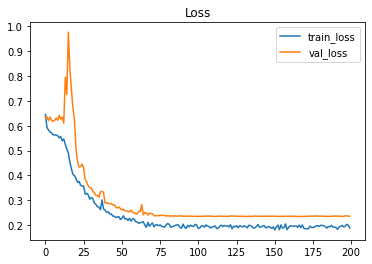

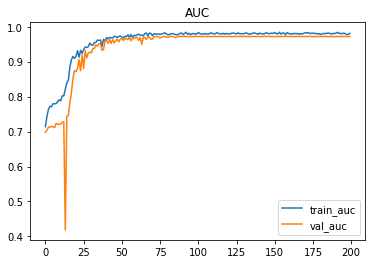

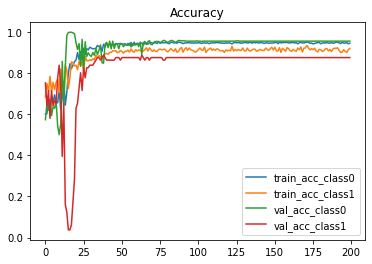

In [22]:
train_history_df = pd.DataFrame.from_dict(train_state)
learning_curve = train_history_df[['train_loss', 'val_loss']].plot.line(title="Loss")
auc_curve = train_history_df[['train_auc', 'val_auc']].plot.line(title="AUC")
acc_curve = train_history_df[['train_acc_class0', 'train_acc_class1',
                             'val_acc_class0', 'val_acc_class1']].plot.line(title="Accuracy")

In [23]:
print(train_history_df)

     train_loss  train_acc_class0  train_acc_class1  train_auc  val_loss  \
0      0.644943          0.601138          0.684783   0.713714  0.631812   
1      0.593219          0.603584          0.750000   0.743534  0.635813   
2      0.582474          0.671353          0.711268   0.763774  0.620728   
3      0.575018          0.620826          0.785211   0.772142  0.634671   
4      0.571537          0.688374          0.709559   0.770982  0.622333   
..          ...               ...               ...        ...       ...   
195    0.192563          0.947115          0.915441   0.981921  0.235146   
196    0.194839          0.947160          0.906574   0.979643  0.236827   
197    0.202720          0.949694          0.901460   0.977288  0.236873   
198    0.198979          0.943668          0.914815   0.978058  0.235575   
199    0.188313          0.946976          0.920863   0.980813  0.235581   

     val_acc_class0  val_acc_class1   val_auc  
0          0.573991        0.753086  0.

tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0.], device='cuda:0', dtype=torch.float64)
tensor([1.5935e-01, 1.1584e-01, 5.1804e-01, 8.3965e-02, 2.6686e-01, 9.7659e-01,
        9.2901e-02, 8.7050e-01, 3.5138e-02, 5.0793e-02, 2.9926e-02, 3.0830e-02,
        6.1298e-02, 1.4455e-01, 1.0657e-02, 5.2134e-02, 1.5182e-01, 4.0148e-02,
        3.8068e-02, 2.4364e-01, 5.5277e-02, 4.2854e-02, 1.4023e-01, 8.6399e-01,
        9.5370e-02, 1.5176e-01, 9.9879e-01, 7.2593e-02, 4.0453e-01, 9.0930e-02,
        1.6423e-01, 1.2334e-01, 8.3614e-02, 4.8388e-02, 1.0472e-0

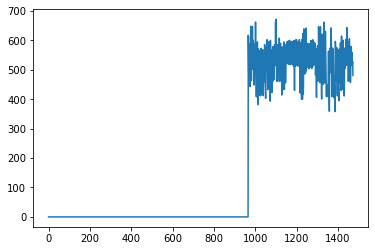

In [24]:
print(y)
print(torch.exp(y_pred[:, 1]))
#plt.plot(x[0].cpu().numpy())
print(x[5].cpu().numpy().squeeze())
plt.plot(x[5].cpu().numpy().squeeze()[:])

In [25]:
for param in tr_net.parameters():
  print(param.data)

tensor([[[-1.5671e-01, -1.3069e-01,  1.9976e-01,  1.6147e-01,  1.8774e-01,
          -8.7493e-03,  1.4287e-01, -1.3958e-01,  6.3520e-02,  1.2713e-01,
          -5.7657e-02, -3.0804e-02,  1.4542e-01, -7.4485e-02, -1.2158e-01,
           8.5981e-02, -2.7292e-02, -1.5681e-01,  5.0747e-02, -6.9489e-02,
          -1.5850e-01, -1.3942e-01,  1.1430e-01,  2.4120e-02,  1.1406e-02,
          -1.3112e-01, -3.1419e-02, -1.2593e-01, -7.3385e-02, -8.8190e-02]],

        [[ 2.5958e-02,  7.5509e-03, -7.0261e-02, -2.7052e-02, -6.8631e-02,
           8.1299e-03, -7.9696e-02, -8.9299e-02,  6.2605e-02,  7.7365e-02,
           1.1827e-01,  6.5876e-02, -8.8224e-02,  1.7293e-01, -1.6788e-01,
          -1.7077e-02, -1.4276e-01, -9.0962e-02,  6.4901e-02,  9.1435e-02,
          -1.2749e-01, -8.6800e-02, -1.1105e-01,  1.3040e-01,  1.8214e-01,
           1.9067e-01,  2.9462e-02, -7.4196e-02, -1.0555e-01,  9.6643e-02]],

        [[-9.1447e-02,  1.2806e-02,  1.1088e-01, -1.7559e-01, -1.6529e-01,
          -1.1816e-